# Classificação de imagens de células com CNN

Esse projeto tem por objetivo treinar uma rede neural para classificar imagens de células e auxiliar no diagnóstico de pacientes infectados ou não por malária. 

Para isso, foi utilizado o banco de imagens celulares [Malaria Cell images Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria), da Kaggle. Esse banco contém 27560 imagens no formato .png, 13780 de células contaminadas por malária e 13780 de células saudáveis, divididas nos diretórios *Parasitized* e *Uninfected*. As imagens variam de tamanho, sendo da faixa de 120x120 pixels.


### Import das bibliotecas necessárias

In [2]:
import tensorflow as tf
import os, shutil
import matplotlib.pyplot as plt 
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model

### Trabalhando com os arquivos

Aqui, o diretório base em que estão as imagens é definido, assim como os subdiretórios de imagens de células infectadas e não infectadas.

Uma lista com os nomes das imagens infectadas e uma com os nomes das não infectadas também é definida.

In [3]:
base_dir = 'D:/Camila/cell_images'
infected_dir = base_dir + '/Parasitized'
uninfected_dir = base_dir + '/Uninfected'

infected_data = os.listdir(infected_dir)
uninfected_data = os.listdir(uninfected_dir)

print('total infected images:', len(infected_data))
print('total uninfected images:', len(uninfected_data))

total infected images: 13780
total uninfected images: 13780


### Mostrando as imagens

Para saber como lidar com o problema, é importante conhecer o banco de dados. Por isso, aqui é mostrado um exemplo de uma imagem de célula infectada e uma não ifectada. Também é mostrada a imagem da célula infectada com o tamanho em que ela será alimentada à rede neural (50x50x3), para conferir se não há perda significativa de informação. 

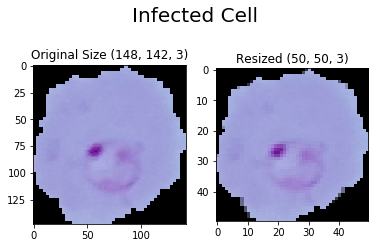

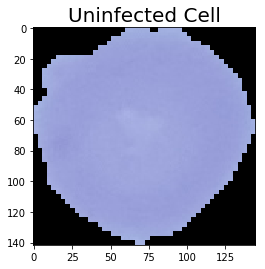

In [52]:
img_infected = cv2.imread(infected_dir + "/" + infected_data[0])
img_infected_resized = cv2.resize(img_infected, (50, 50))

fig, (fig1, fig2) = plt.subplots(1,2)
fig.suptitle('Infected Cell', fontsize=20)
fig1.imshow(img_infected)
fig2.imshow(img_infected_resized)

fig1.set_title('Original Size %s'%(img_infected.shape,))
fig2.set_title('Resized %s' %(img_infected_resized.shape,))

plt.show()


img_uninfected = cv2.imread(uninfected_dir + "/" + uninfected_data[2])

plt.imshow(img_uninfected)
plt.title('Uninfected Cell', fontsize=20)
plt.show()


### Pré-processamento das imagens e divisão dos dados em lotes de treino e validação

Aqui, para realizar o pré-processamento das imagens e a divisão dos dados em dados de treino e validação, usa-se a classe *ImageDataGenerator* do Keras, que normaliza os valores de pixel para valores entre 0 e 1 e separa 20% dos dados de cada diretório para validação. Como as imagens do banco de dados já vieram centralizadas, nenhuma outra operação de pré-processamento foi necessária.

As imagens sofreram uma redução de tamanho para 50x50 (não há perda significativa de informação na imagem reduzida, como mostrado na seção anterior), para acelerar o processamento. Também definiu-se o vetor de saída como 'categorical', ou seja, um vetor 2D com as labels (infectada, não-infectada) em one-hot enconding.


In [7]:
#gerando os lotes de treino e validação 

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    base_dir,
    target_size = (50,50),
    batch_size=16,
    class_mode = 'categorical', #ou binária quando houver apenas uma saída com ativação sigmoide
    subset='training')

val_data = datagen.flow_from_directory(
    base_dir,
    target_size = (50,50),
    batch_size=16,
    class_mode = 'categorical',
    subset='validation')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


### Construção do modelo

O modelo inicial foi construído empilhando-se 3 camadas convolucionais, cada uma seguida e uma camada maxpooling para redução de dimensionalidade. Depois, empilhou-se duas camadas densamente conectadas, sendo a última a camada de saída. 

In [14]:
# Construção do modelo
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
__________

### Configuração e treinamento o modelo

In [16]:
#Configuração do modelo
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [17]:
# Treinamento do modelo e validação
history = model.fit_generator(train_data,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_data,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 21s 208ms/step - loss: 0.6875 - acc: 0.5575 - val_loss: 0.7280 - val_acc: 0.5250 3s - loss:
Epoch 2/30
100/100 [==============================] - 22s 223ms/step - loss: 0.6654 - acc: 0.5950 - val_loss: 0.6019 - val_acc: 0.7350
Epoch 3/30
100/100 [==============================] - 23s 235ms/step - loss: 0.5876 - acc: 0.7006 - val_loss: 0.4675 - val_acc: 0.8337
Epoch 4/30
100/100 [==============================] - 27s 272ms/step - loss: 0.3185 - acc: 0.8656 - val_loss: 0.2050 - val_acc: 0.9313
Epoch 5/30
100/100 [==============================] - 22s 224ms/step - loss: 0.2151 - acc: 0.9262 - val_loss: 0.1872 - val_acc: 0.9313
Epoch 6/30
100/100 [==============================] - 24s 241ms/step - loss: 0.2307 - acc: 0.9262 - val_loss: 0.2478 - val_acc: 0.9150
Epoch 7/30
100/100 [==============================] - 22s 222ms/step - loss: 0.1799 - acc: 0.9437 - val_loss: 0.1984 - val_acc: 0.9253
Epoch 8/30
100/100 [========================

### Visualização das métricas (acurácia e perda) 

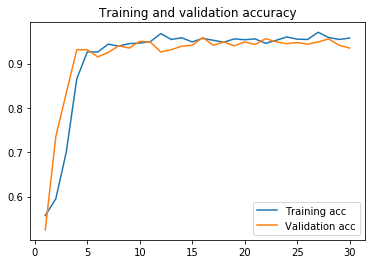

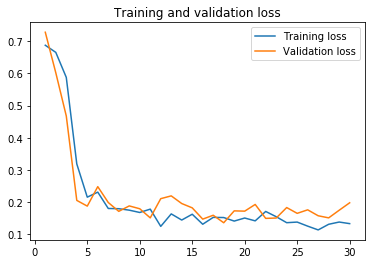

In [35]:
# Visualizando as métricas do treino e da validação
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Pode-se observar que o mdelo chegou a encontrar 95% de acurácia na validação (época 22). Também pode-se notar que o modelo convergeu rapidamente para uma acurácia acima de 90%, levando apenas 4 épocas para tal.

## Outros modelos

### Removendo uma camada ConvNet 

Como as imagens a serem classificadas não possuem muitas *features* a serem descobertas, optou-se por remover uma camada convolucional, o que tornaria o treinamento do modelo mais rápido.

In [8]:
# Construção do modelo
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(2, activation='softmax'))

model3.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3965440   
_________________________________________________________________
dens

In [9]:
# Configuração do modelo3
model3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])

In [29]:
# Treinamento do modelo
history3 = model3.fit_generator(train_data,
    steps_per_epoch=100,
    epochs=20,
    validation_data=val_data,
    validation_steps=50)

Epoch 1/20
100/100 [==============================] - 18s 180ms/step - loss: 0.7257 - acc: 0.5406 - val_loss: 0.6786 - val_acc: 0.5725 acc: 0.51 - ETA: 4s - loss:  - ETA: 1s - loss: 0.7333 - a
Epoch 2/20
100/100 [==============================] - 17s 173ms/step - loss: 0.6481 - acc: 0.6256 - val_loss: 0.5836 - val_acc: 0.7100s: 0.6475 - acc: 0.626
Epoch 3/20
100/100 [==============================] - 18s 177ms/step - loss: 0.6080 - acc: 0.6675 - val_loss: 0.6471 - val_acc: 0.6212cc:  - ETA: 4s - loss: 0.6 - ETA: 2s - loss: 0.6
Epoch 4/20
100/100 [==============================] - 17s 168ms/step - loss: 0.5443 - acc: 0.7369 - val_loss: 0.4986 - val_acc: 0.7684
Epoch 5/20
100/100 [==============================] - 17s 171ms/step - loss: 0.3941 - acc: 0.8469 - val_loss: 0.2884 - val_acc: 0.9050c - ETA: 9s -  - ETA: 6s - loss: 0.4214 - acc:  - ETA: 5s - loss: 0.4214 - acc: 0. - ETA: 4s - loss: 0. - ETA: 1s - loss: 0.4038 - acc: 0 - ETA: 1s - loss: 0.4020 - acc
Epoch 6/20
100/100 [=========

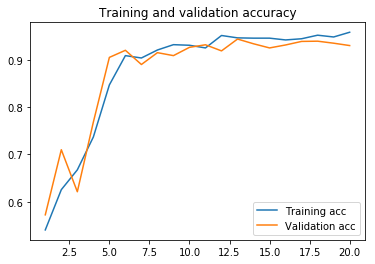

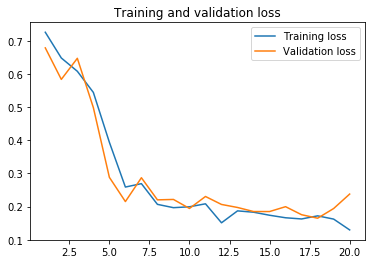

In [30]:
# Visualizando as métricas do treino e da validação
acc = history3.history['acc']
val_acc = history3.history['val_acc']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

O novo modelo chegou a encontrar 94% de acurácia (época 13) na validação. Demorou mais épocas para convergir para uma acurácia acima de 90% (6 épocas), mas cada época leva menos tempo para rodar.

## Conclusão

Pode-se concluir que os modelos treinados são bons classificadores para células infectadas com malária ou não, atingindo 95% 
de acurácia na base de validação. Isso mostra como a CNN é muito adequada para classificação de imagens.

Também percebe-se que não houve problema de *overfitting* e o tempo de treinamnto e validação foi baixo. Isso se deve em grande parte pela boa base de dados utilizada. A base tem muitos exemplos de imagens, permitindo um bom treinamento (além de descartar a necessidade de se fazer aumento de dados). A base também é balanceada, ou seja, tem a mesma quantidade de imagens das duas classificações. As imagens já são pré-processadas, com a célula centralizada, facilitando o trabalho da rede.

Esse trabalho também mostra como redes nerais podem ser úteis no auxílio ao diagnóstico médico.